<div class="alert alert-block alert-info">

## Повышение качества работы с клиентами в сети фитнес-центров "Культурист-датасаентист"   

### Цель:
Разработать рекомендации по повышению качества работы с клиентами:

- выделить целевые группы клиентов;
- предложить меры по снижению оттока;
- определить другие особенности взаимодействия с клиентами.
</div>

### Описание данных:

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:
Данные пользователя за предыдущий до проверки факта оттока месяц:
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент в таком случае фитнес-центр хранит информацию о работодателе клиента)
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

### Оглавление:  <a id="run"></a>  
</div>

1. [Шаг 1](#step1) Загрузка данных и изучение общей информации. 
2. [Шаг 2](#step2) Исследовательский анализ данных (EDA).
3. [Шаг 3](#step3) Построение модели прогнозирования оттока пользователей.
4. [Шаг 4](#step4) Кластеризация пользователей.
5. [Шаг 5](#step5) Общие выводы.

Импортируем необходимые библиотеки и методы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
from plotly import graph_objects as go
from scipy import stats as st
import math as mth
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
import warnings
warnings.filterwarnings('ignore')

### [Шаг 1.](#run) Загрузка данных и изучение общей информации. <a id="step1"></a>   
</div>  

In [3]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Мы видим, что у нас имеется 4000 наблюдений, а также мы видим,что пропущенных значений у нас нет. Присутствуют только числовые типы данных.

### [Шаг 2.](#run)  Исследовательский анализ данных (EDA). <a id="step2"></a>   
</div>  

Проверим датафрейм на наличие дубликатов.

In [5]:
gym_churn.duplicated().sum()

0

Дубликатов не оказалось.

In [6]:
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


В столбцах 'gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits', 'Churn' что-то типа булевого типа данных. Возможен вариант только 1 или 0.

Приведем названия колонок к нижнему регистру.

In [7]:
gym_churn.columns = map(str.lower, gym_churn.columns)

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Так как Churn это факт оттока, то получается, что 1 - это ушел, а 0 - остался (или не ушел).

In [8]:
gym_churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

In [9]:
left = gym_churn.query('churn == 1')
stayed = gym_churn.query('churn == 0')

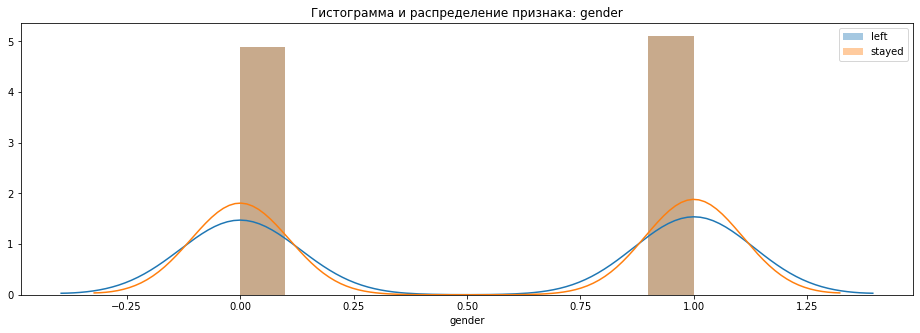

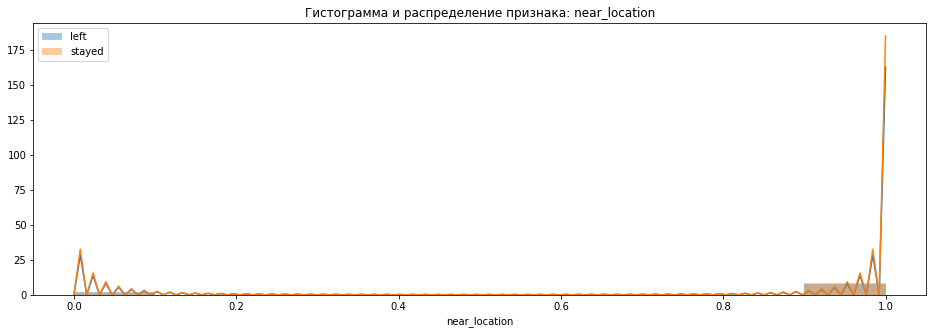

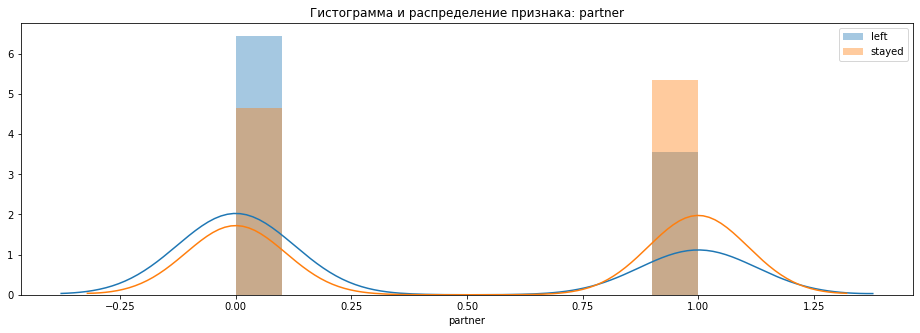

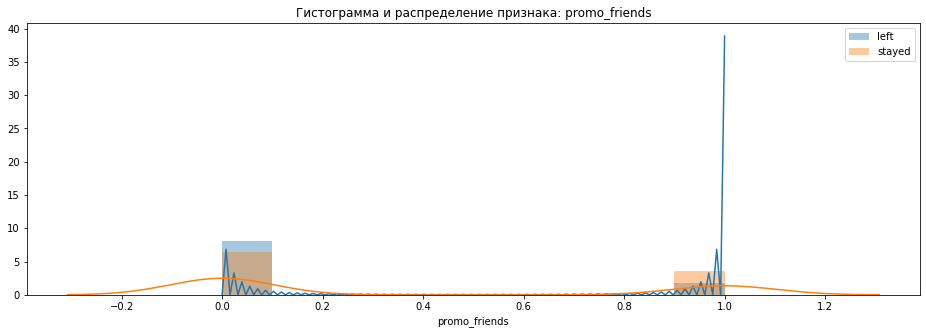

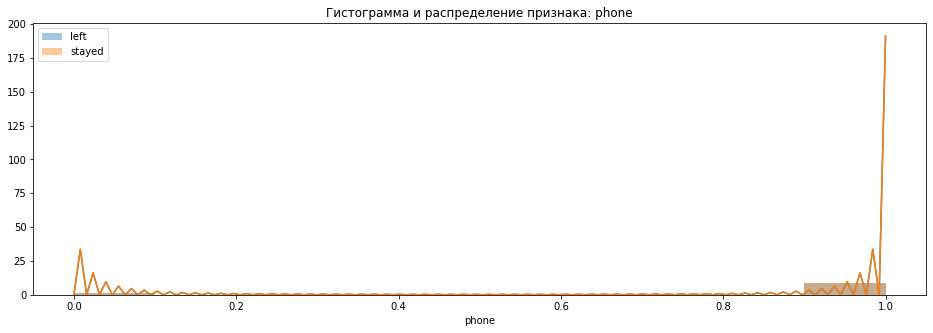

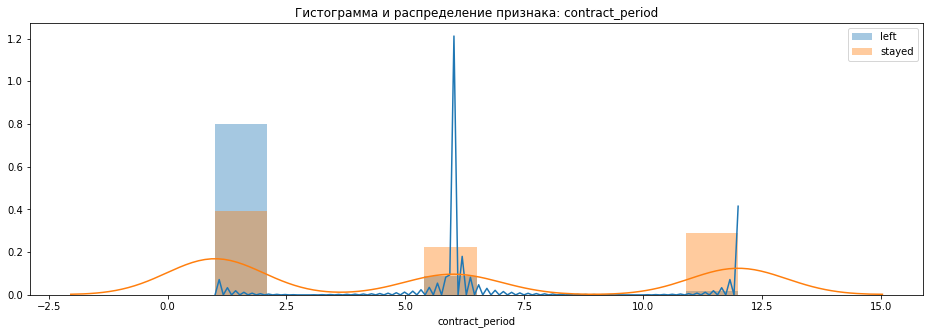

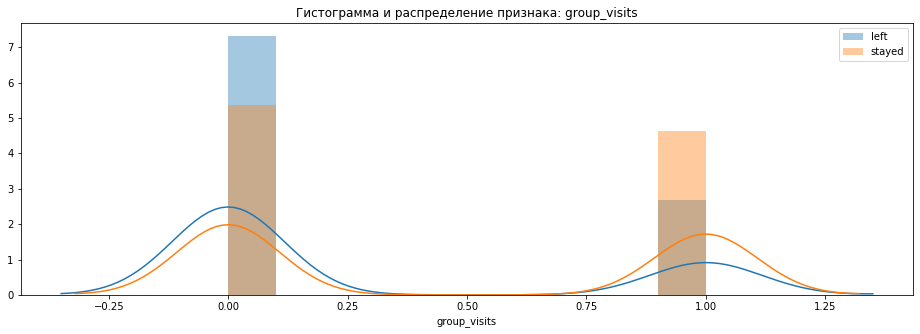

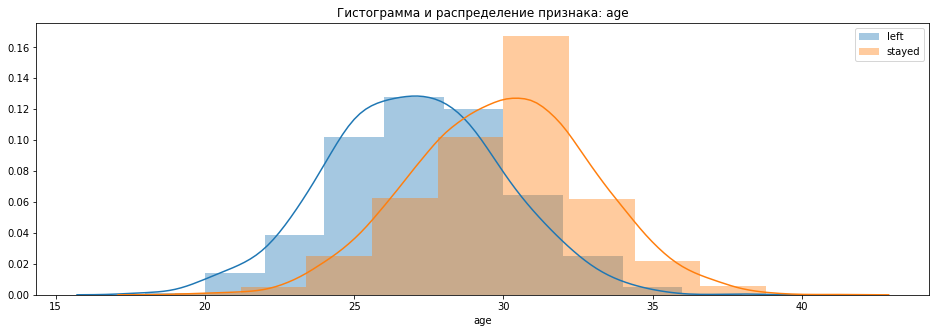

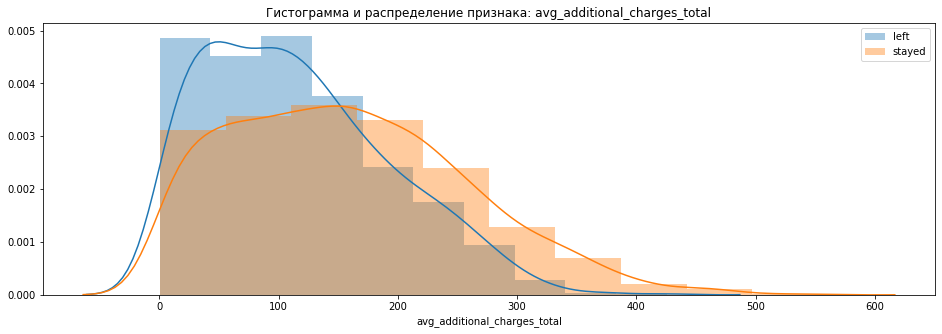

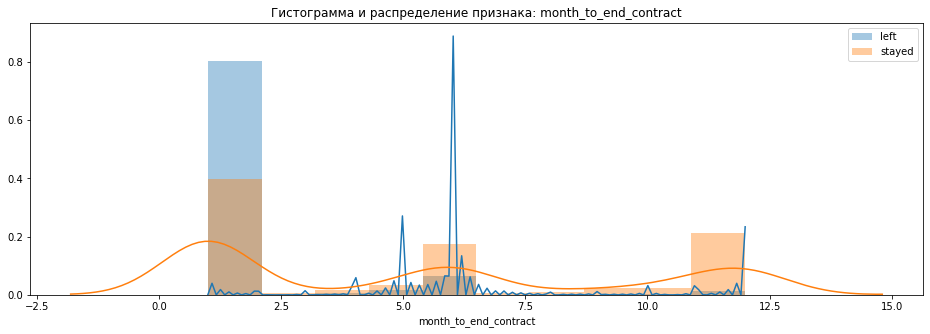

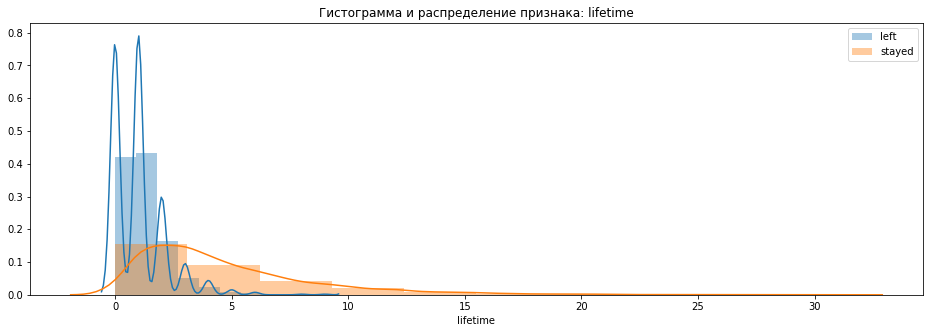

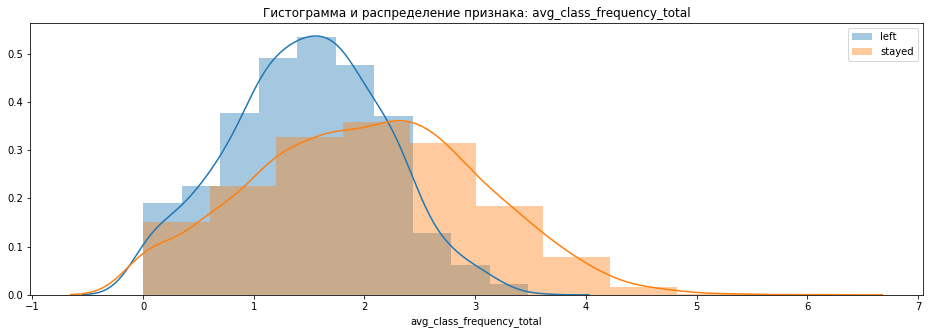

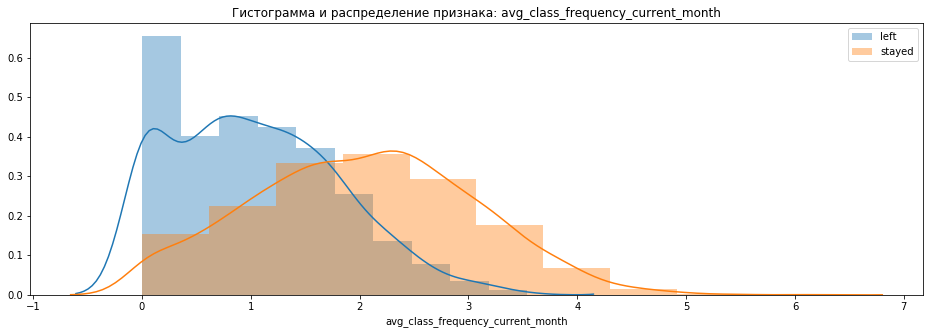

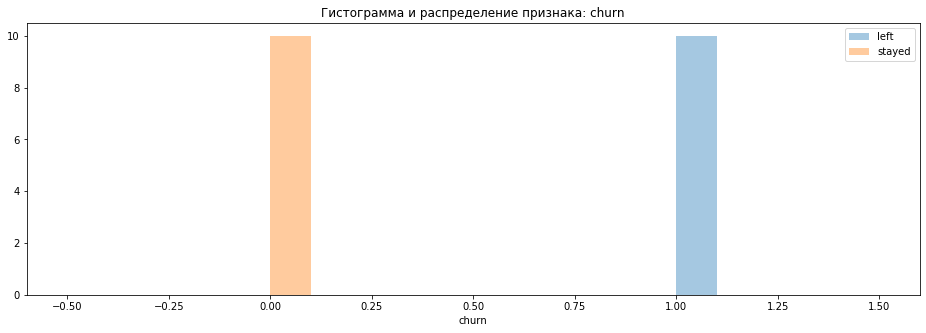

In [10]:
for col in gym_churn.columns:
    plt.subplots(figsize = (16,5))
    sns.distplot(left[col], label='left', bins=10)
    sns.distplot(stayed[col], label='stayed', bins=10)
    plt.title(('Гистограмма и распределение признака: {}'.format(col)))
    plt.legend()
    plt.show()

По половому признаку разделение примерно поровну и у тех, кто ушел и у тех кто остался. Средний возраст у тех кто остается выше(около 31), чем у тех, кто ушел(около 26). Когда клиент является и сотрудником, то остается гораздо чаще. И тот, кто остается, также оставляет и телефон, пользуется различными услугами, типа приведи друга. Также, когда клиент проживает близко к фитнес-центру, он остается немного чаще. Те, кто остались, в среднем чаще посещают зал в неделю(2-3), а также приносят больше выручки с других услуг фитнес-центра(150-180) против тех, кто ушел(до 100).
Те, кто ушли, приобретали в основном абонемент на 1 месяц, в отличие тех, кто остался, у них абонемент и на 6 месяцев и на 1 год. Значит те, кто приобретали абонемент на 1 месяц в последствие остались недовольны чем-либо и ушли.

Мы видим, что выбросы содержатся, в основном, в данных тех, кто ушел. В этих ситуациях график становится c множеством вершин.

Построим матрицу корреляций признаков.

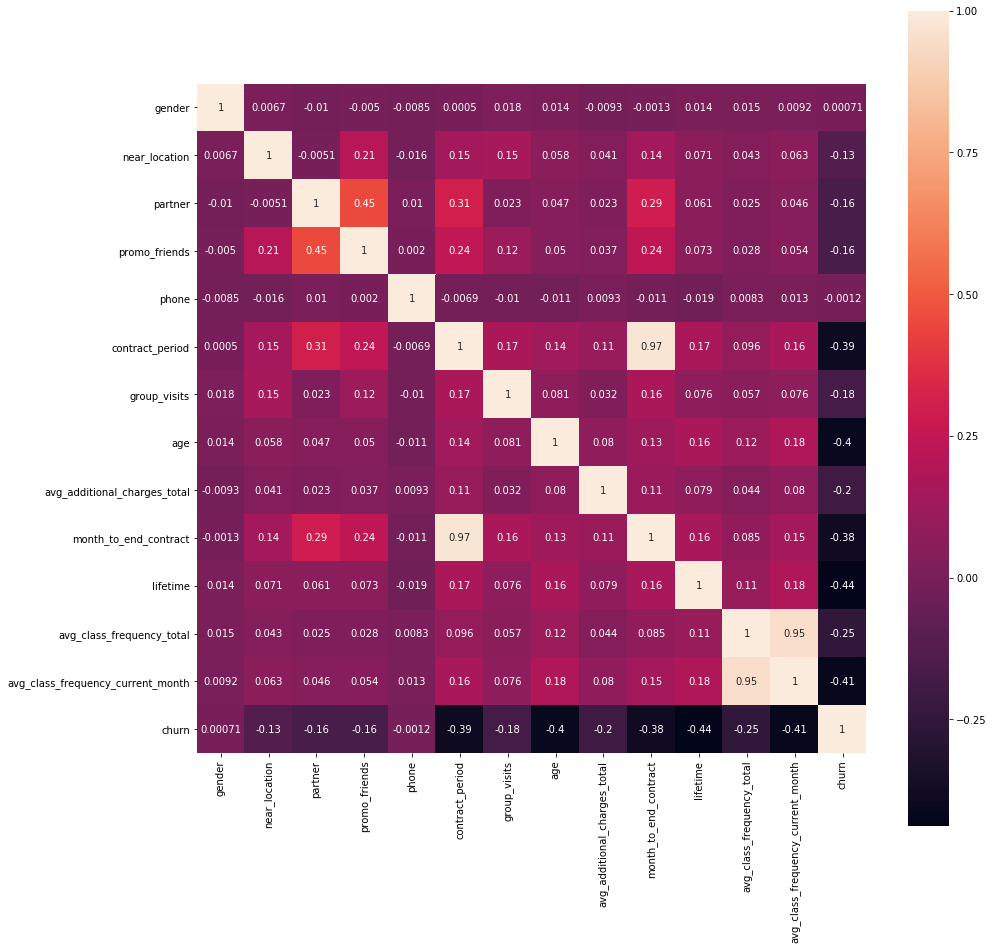

In [11]:
plt.subplots(figsize = (15,15))
hm = sns.heatmap(gym_churn.corr(), annot = True, square=True)

Мы видим, что есть две пары признаков, которые коррелируют между собой сильнее, чем остальные. Поэтому уберем по одному из признаков в каждой паре, чтобы избавиться от мультиколлинеарности.

In [12]:
gym_churn.drop('month_to_end_contract', axis = 1, inplace = True)

In [13]:
gym_churn.drop('avg_class_frequency_current_month', axis = 1, inplace = True)

Мы можем видеть, что прзнаки между собой почти не коррелируют.

### [Шаг 3.](#run)  Постройте модель прогнозирования оттока пользователей. <a id="step3"></a>   
</div>  

Определим функцию, которая будет выводить наши метрики

In [14]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))


Разделим наши данные на признаки (матрица X) и целевую переменную (y)

In [15]:
X = gym_churn.drop('churn', axis = 1) 
y = gym_churn['churn'] 

Разделяем модель на обучающую и валидационную выборки

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Создадим объект класса StandardScaler и обучим его на обучающей выборке.

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

Преобразуем обучающий и валидационный наборы данных.

In [18]:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Зададим и обучим алгоритм для модели логистической регрессии

In [19]:
lr_model = LogisticRegression(random_state = 0)
lr_model.fit(X_train_st, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Воспользуемся уже обученной моделью, чтобы сделать прогнозы

In [20]:
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

Зададим и обучим алгоритм для новой модели на основе алгоритма случайного леса.

In [21]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Воспользуемся уже обученной моделью, чтобы сделать прогнозы

In [22]:
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

______________________________________________________________________________________________________________________________________

Выведем все метрики модели логистической регрессии:

In [23]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81


______________________________________________________________________________________________________________________________________

Выведем все метрики модели случайного леса:

In [24]:
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.79
	Recall: 0.76


______________________________________________________________________________________________________________________________________

Метрика accuracy, или доля правильных ответов. Это доля верно угаданных ответов из всех прогнозов. Чем ближе значение accuracy к 100%, тем лучше. В модели логистической регрессии эта метрика составляет 90% из 100%, а вмодели случайного леса 89% из 100%. Значит лучше сработала модель логистической регрессии.

Метрика precision, или точность, говорит, какая доля прогнозов относительно "1" класса верна. В обоих моделях эти метрики одинаковые.

Метрика recall, или полнота, показывает сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. В этой ситуации сработала лучше модель логистической регрессии, так как нам необходимо выявить тех, кто уходит, почему он уходит и понть почему.

Исходя из этого, в нашей ситуации лучше работает модель логистической регрессии.

### [Шаг 4.](#run)  Кластеризация пользователей. <a id="step4"></a>   
</div>  

In [25]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(gym_churn.drop(columns = ['churn']))

In [26]:
linked = linkage(x_sc, 'ward')

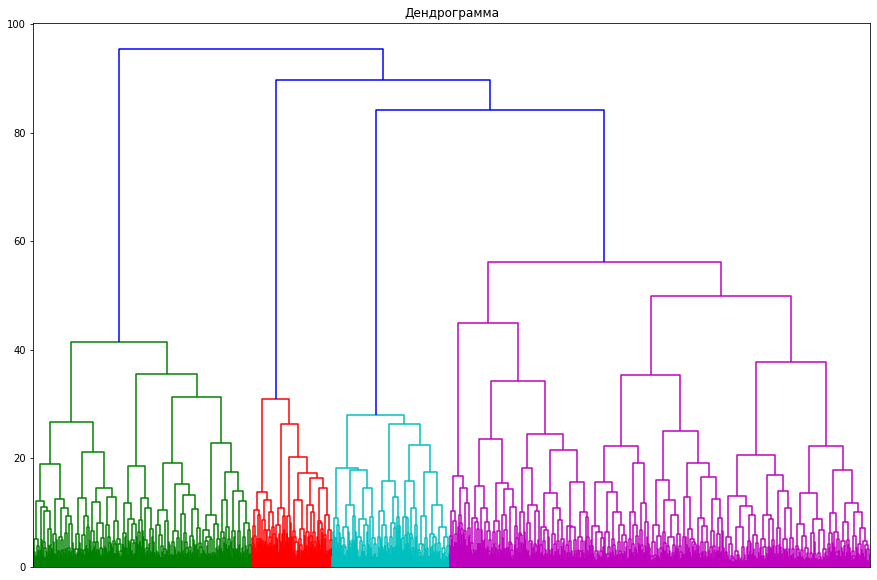

In [27]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.xticks([])
plt.show()

Визуально мы можем обнаружить 6 кластеров, но в соответствии с условием задания - задаём модель k_means с числом кластеров 5.

In [28]:
km = KMeans(n_clusters = 5, random_state=0)

Прогнозируем кластеры для наблюдений.

In [29]:
labels = km.fit_predict(x_sc)

Сохраняем метки кластера в поле датасета

In [30]:
gym_churn['cluster_km'] = labels

Получим статистику по средним значениям признаков по кластеру.

In [31]:
clasters = gym_churn.groupby(['cluster_km']).mean().reset_index()
clasters['cluster_km'] = [1,2,3,4,5]
clasters

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,2,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,3,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,4,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,5,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Для каждого полученного кластера посмотрим долю оттока

In [32]:
clasters[['cluster_km', 'churn']]

,cluster_km,churn
0,1,0.399287
1,2,0.120952
2,3,0.381625
3,4,0.200918
4,5,0.266839


Мы видим, что доля оттока больше всего в кластере 1 и меньше всего в кластере 2.

Построим гистограммы признаков для кластеров.

In [33]:
cl1 = gym_churn.query('cluster_km == 0')
cl2 = gym_churn.query('cluster_km == 1')
cl3 = gym_churn.query('cluster_km == 2')
cl4 = gym_churn.query('cluster_km == 3')
cl5 = gym_churn.query('cluster_km == 4')

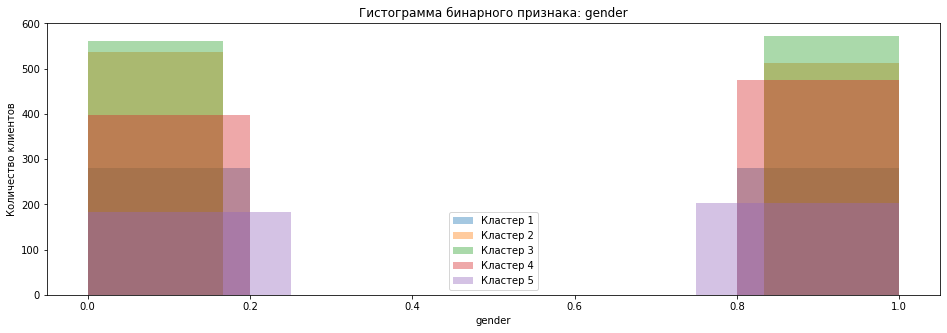

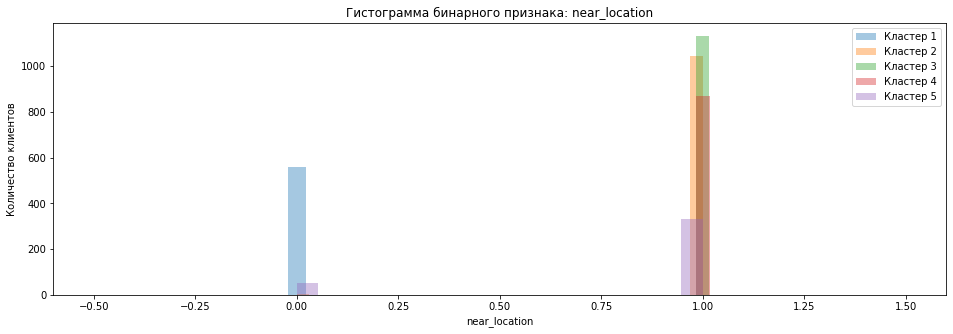

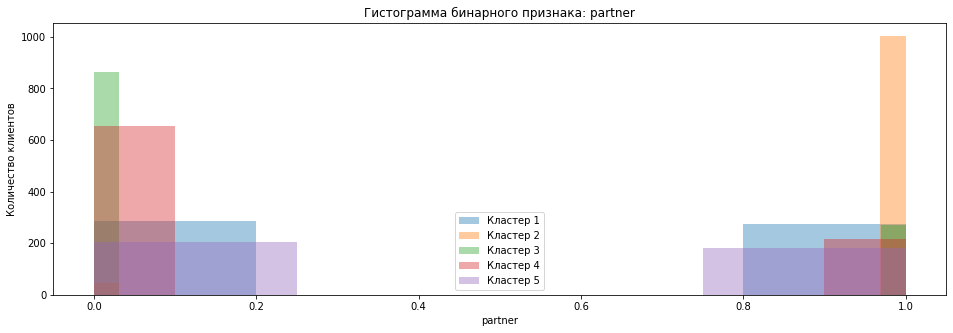

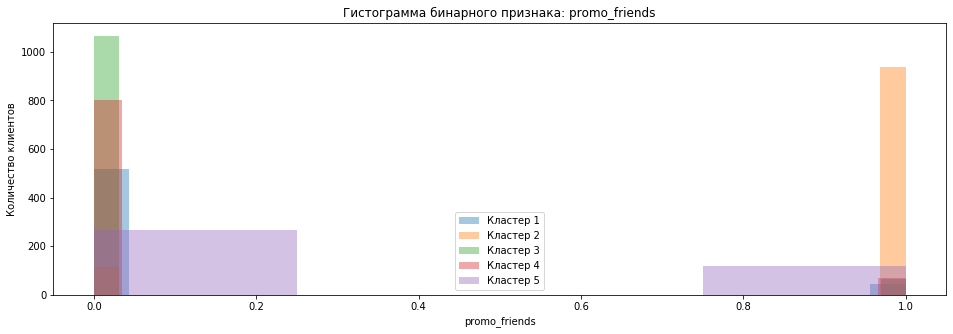

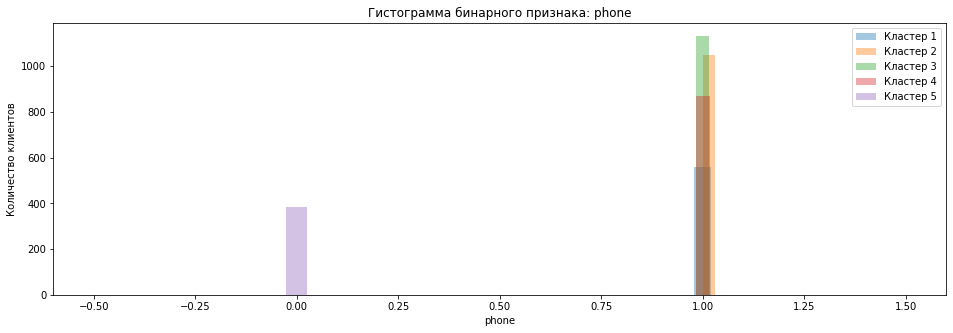

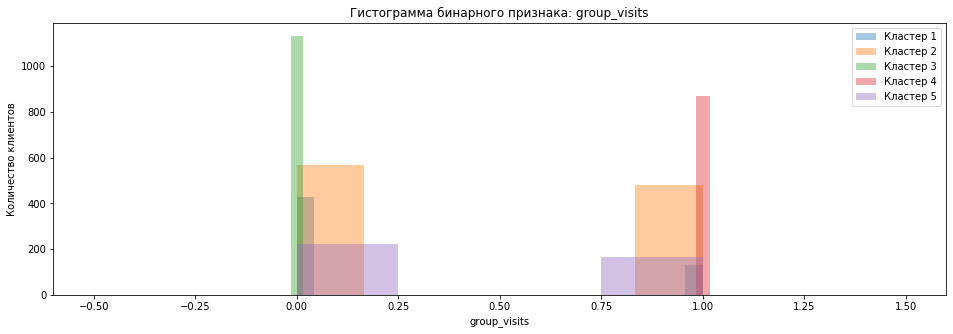

In [34]:
for col2 in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.subplots(figsize = (16,5))
    sns.distplot(cl1[col2], label='Кластер 1', kde=False)
    sns.distplot(cl2[col2], label='Кластер 2', kde=False)
    sns.distplot(cl3[col2], label='Кластер 3', kde=False)
    sns.distplot(cl4[col2], label='Кластер 4', kde=False)
    sns.distplot(cl5[col2], label='Кластер 5', kde=False)
    plt.title(('Гистограмма бинарного признака: {}'.format(col2)))
    plt.ylabel('Количество клиентов')
    plt.legend()
    plt.show()

Построим распределения численных признаков для кластеров.

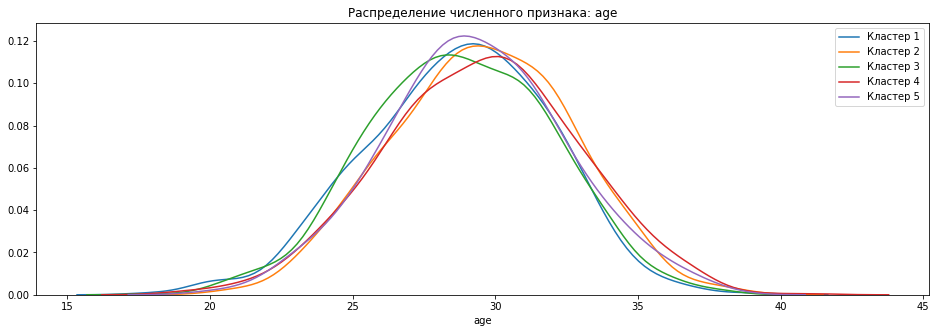

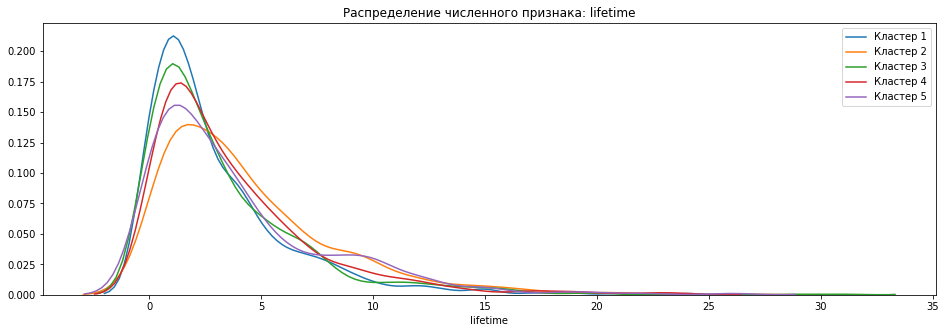

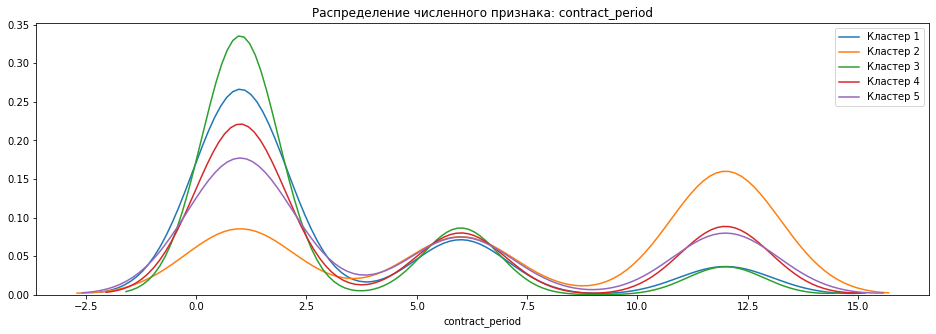

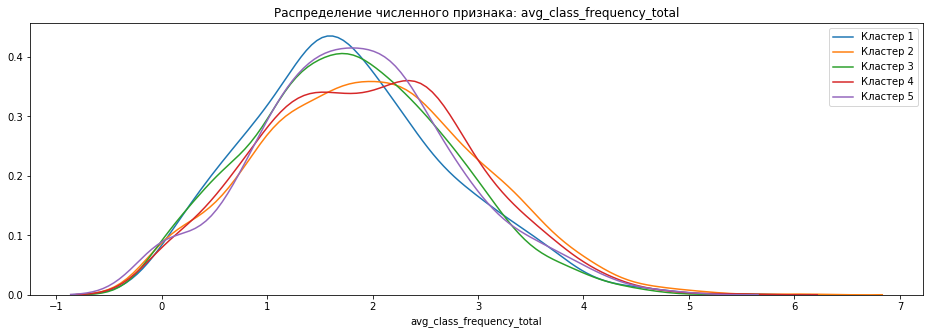

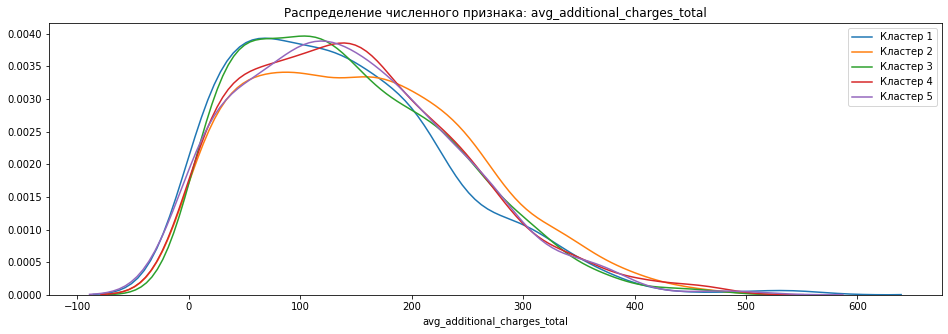

In [35]:
for col2 in ['age', 'lifetime', 'contract_period', 'avg_class_frequency_total', 'avg_additional_charges_total']:
    plt.subplots(figsize = (16,5))
    sns.distplot(cl1[col2], label='Кластер 1', bins=10, hist=False)
    sns.distplot(cl2[col2], label='Кластер 2', bins=10, hist=False)
    sns.distplot(cl3[col2], label='Кластер 3', bins=10, hist=False)
    sns.distplot(cl4[col2], label='Кластер 4', bins=10, hist=False)
    sns.distplot(cl5[col2], label='Кластер 5', bins=10, hist=False)
    plt.title(('Распределение численного признака: {}'.format(col2)))
    plt.legend()
    plt.show()

### Портрет(отличительные особенности) клиентов в кластерах по бинарным признакам:
- 1 кластер: проживание или работа не в том районе, где находится фитнес-центр;
- 2 кластер: почти все пришли с промо-кодом от своих знакомых, в рамках акции "Приведи друга"; почти все являются сотрудниками компаний-партнеров;
- 3 кластер: все из этого кластера посещали групповые тренировки; все клиенты не являются сотрудниками компаний-партнеров;
- 4 кластер: все из этого кластера не посещали групповые тренировки; почти все пришли без промо-кода в рамках акции "Приведи друга";
- 5 кластер: клиенты, которые не оставляли номер своего телефона;

Рассматривая это вместе с долей оттока по кластерам, можно предположить, что максимальная доля оттка в том кластере клиентов, которые проживают достаточно удаленно от фитнес-центра. Самая минимальная у тех людей, которые пришли по приглашению своих знакомых или являются сотрудниками компаний-партнеров.

### Портрет(отличительные особенности) клиентов в кластерах по числовым признакам:
- 1 кластер: -
- 2 кластер: имеют максимальное время активности в фитнес-центре с момента первого обращения; длительность текущего абонемента у них максимальная; приносит максимальную суммарную выручку от других услуг фитнес-центра;
- 3 кластер: все из этого кластера имеют минимальный возраст из общей выборки;
- 4 кластер: все из этого кластера имеют максимальный возраст из общей выборки; в среднем чаще всего посещает фитнес-клуб в неделю;
- 5 кластер: -

### [Шаг 5.](#run) Общие выводы. <a id="step5"></a>   
</div>

#### Портрет тех клиентов, кто остался в фитнес-центре на период сбора информации и тех, кто ушел.
- По половому признаку разделение примерно поровну и у тех, кто ушел и у тех кто остался. 
- Средний возраст у тех кто остается выше(около 31), чем у тех, кто ушел(около 26). 
- Когда клиент является и сотрудником, то остается гораздо чаще. 
- Тот, кто остается, также оставляет и телефон, пользуется различными услугами, типа приведи друга. 
- Когда клиент проживает близко к фитнес-центру, он остается немного чаще. 
- Те, кто остались, в среднем чаще посещают зал в неделю(2-3), а также приносят больше выручки с других услуг фитнес-центра(150-180) против тех, кто ушел(до 100).
- Те, кто ушли, приобретали в основном абонемент на 1 месяц, в отличие тех, кто остался, у них абонемент и на 6 месяцев и на 1 год. Значит те, кто приобретали абонемент на 1 месяц в последствие остались недовольны чем-либо и ушли.

#### Определение наиболее эффективной модели:

- Метрика accuracy, или доля правильных ответов. В модели логистической регрессии эта метрика составляет 90% из 100%, а в модели случайного леса 89% из 100%. Значит лучше сработала модель логистической регрессии.

- Метрика precision, или точность. В обоих моделях эти метрики одинаковые.

- Метрика recall. В этой ситуации сработала лучше модель логистической регрессии, так как нам необходимо выявить тех, кто уходит, почему он уходит и понять почему.

Исходя из этого, в нашей ситуации лучше работает модель логистической регрессии.

### Портрет(отличительные особенности) клиентов в кластерах по бинарным признакам:
- 1 кластер: проживание или работа не в том районе, где находится фитнес-центр;
- 2 кластер: почти все пришли с промо-кодом от своих знакомых, в рамках акции "Приведи друга"; почти все являются сотрудниками компаний-партнеров;
- 3 кластер: все из этого кластера посещали групповые тренировки; все клиенты не являются сотрудниками компаний-партнеров;
- 4 кластер: все из этого кластера не посещали групповые тренировки; почти все пришли без промо-кода в рамках акции "Приведи друга";
- 5 кластер: клиенты, которые не оставляли номер своего телефона;

Максимальная доля оттока в том кластере клиентов, которые проживают достаточно удаленно от фитнес-центра. Самая минимальная у тех людей, которые пришли по приглашению своих знакомых или являются сотрудниками компаний-партнеров.

### Портрет(отличительные особенности) клиентов в кластерах по числовым признакам:
- 1 кластер: -
- 2 кластер: имеют максимальное время активности в фитнес-центре с момента первого обращения; длительность текущего абонемента у них максимальная; приносит максимальную суммарную выручку от других услуг фитнес-центра;
- 3 кластер: все из этого кластера имеют минимальный возраст из общей выборки;
- 4 кластер: все из этого кластера имеют максимальный возраст из общей выборки; в среднем чаще всего посещает фитнес-клуб в неделю;
- 5 кластер: -

### Рекомендации для стратегии взаимодействия с пользователями и их удержания:
- рекламировать те предложения, которые бы были интересны потенциальным клиентам из кластеров, которые являются положительными;
- как только клиент начинает сокращать свои посещения, до того, как он уйдет, связаться и сделать персональное предложение, скидка на те услуги, которые ему могут быть интересны или предложить то, чем он не пользовался(превратить оттекающего клиента в потенциального);
- при рассторжении контракта или сокращении посещений, выдавать анкету(или высылать по почте), с пунктами, которые могут привлекать и отторгать клиентов, потенциально, можно будет лучше разобраться с тем, что их не устроило;
- сегментировать уже ушедших клиентов и определить какие наиболее частые причины ухода. Сделать некоторые изменения для их устранения.